In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input
/kaggle/input/eeg-signal
/kaggle/input/eeg-signal/BCICIV_2a_gdf
/kaggle/input/eeg-signal/normalized
/kaggle/input/eeg-signal/raw


In [2]:
!pip install mne
!pip install optuna pytorch_lightning
!pip install optuna.integration[pytorch_lightning]`

/bin/bash: -c: line 0: unexpected EOF while looking for matching ``'
/bin/bash: -c: line 1: syntax error: unexpected end of file


In [3]:
import mne
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
file_paths = [f"/kaggle/input/eeg-signal/BCICIV_2a_gdf/A0{i}T.gdf" for i in range(1, 10)]  

all_data = []
all_labels = []

event_ids = {
    'left_hand': 7,   
    'right_hand': 8,   
    'feet': 9,         
    'tongue': 10       
}

for file_path in file_paths:
    raw = mne.io.read_raw_gdf(file_path, preload=True)
    raw.notch_filter(freqs=50)# Notch filter
    raw.filter(8., 30., fir_design='firwin')#Band-Pass Filter to Retain Frequencies of Interest
    raw.set_eeg_reference('average')# Re-reference the EEG Signals
    
    events, event_dict = mne.events_from_annotations(raw)
    print(f"Available events in {file_path}: {event_dict}")
    
    available_event_ids = {key: event_ids[key] for key in event_ids if event_ids[key] in event_dict.values()}
    
    if not available_event_ids:
        print(f"No motor imagery tasks found in {file_path}. Skipping this file.")
        continue  
    
    epochs = mne.Epochs(raw, events, event_id=available_event_ids, tmin=0, tmax=2, baseline=None, preload=True)
    
    X = epochs.get_data() 
    X_normalized = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    y = epochs.events[:, -1] - min(available_event_ids.values())  
    
    all_data.append(X_normalized)
    all_labels.append(y)

X_combined = np.concatenate(all_data, axis=0) 
y_combined = np.concatenate(all_labels, axis=0)  

X_tensor = torch.tensor(X_combined, dtype=torch.float32).unsqueeze(1) 
y_tensor = torch.tensor(y_combined, dtype=torch.long)

Extracting EDF parameters from /kaggle/input/eeg-signal/BCICIV_2a_gdf/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...


/opt/conda/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Reading 0 ... 672527  =      0.000 ...  2690.108 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Available events in /kaggle/input/eeg-signal/BCICIV_2a_gdf/A01T.gdf: {'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '769': 7, '770': 8, '771': 9, '772': 10}
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 501 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/eeg-signal/BCICIV_2a_gdf/A02T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structu

/opt/conda/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Available events in /kaggle/input/eeg-signal/BCICIV_2a_gdf/A02T.gdf: {'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '769': 7, '770': 8, '771': 9, '772': 10}
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 501 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/eeg-signal/BCICIV_2a_gdf/A03T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structu

/opt/conda/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Available events in /kaggle/input/eeg-signal/BCICIV_2a_gdf/A03T.gdf: {'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '769': 7, '770': 8, '771': 9, '772': 10}
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 501 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/eeg-signal/BCICIV_2a_gdf/A04T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structu

/opt/conda/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: ['1023', '1072', '32766', '768', '769', '770', '771', '772']
Available events in /kaggle/input/eeg-signal/BCICIV_2a_gdf/A04T.gdf: {'1023': 1, '1072': 2, '32766': 3, '768': 4, '769': 5, '770': 6, '771': 7, '772': 8}
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 144 events and 501 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/eeg-signal/BCICIV_2a_gdf/A05T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 686119  =      0.000 ...  2744.476 secs...


/opt/conda/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Available events in /kaggle/input/eeg-signal/BCICIV_2a_gdf/A05T.gdf: {'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '769': 7, '770': 8, '771': 9, '772': 10}
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 501 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/eeg-signal/BCICIV_2a_gdf/A06T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structu

/opt/conda/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Available events in /kaggle/input/eeg-signal/BCICIV_2a_gdf/A06T.gdf: {'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '769': 7, '770': 8, '771': 9, '772': 10}
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 501 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/eeg-signal/BCICIV_2a_gdf/A07T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structu

/opt/conda/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Available events in /kaggle/input/eeg-signal/BCICIV_2a_gdf/A07T.gdf: {'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '769': 7, '770': 8, '771': 9, '772': 10}
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 501 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/eeg-signal/BCICIV_2a_gdf/A08T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structu

/opt/conda/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Available events in /kaggle/input/eeg-signal/BCICIV_2a_gdf/A08T.gdf: {'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '769': 7, '770': 8, '771': 9, '772': 10}
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 501 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/eeg-signal/BCICIV_2a_gdf/A09T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structu

/opt/conda/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Available events in /kaggle/input/eeg-signal/BCICIV_2a_gdf/A09T.gdf: {'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '769': 7, '770': 8, '771': 9, '772': 10}
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 501 original time points ...
0 bad epochs dropped


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42, stratify=y_tensor)


train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
batch_size=64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



class EEGAutoencoder(nn.Module):
    def __init__(self, n_channels=22, n_times=501, latent_dim=64):
        super(EEGAutoencoder, self).__init__()
        self.n_channels = n_channels
        self.n_times = n_times
        input_dim = n_channels * n_times
        
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
        )
        
    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        x_recon = x_recon.view(-1, 1, self.n_channels, self.n_times)
        return x_recon, z

n_channels = X_tensor.shape[2]
n_times = X_tensor.shape[3]
latent_dim = 64
ae = EEGAutoencoder(n_channels=n_channels, n_times=n_times, latent_dim=latent_dim)
ae_optimizer = optim.Adam(ae.parameters(), lr=1e-3)
ae_criterion = nn.MSELoss()


num_epochs_ae = 50
for epoch in range(num_epochs_ae):
    ae.train()
    total_loss = 0.0
    for X_batch, _ in train_loader:
        ae_optimizer.zero_grad()
        X_recon, _ = ae(X_batch)
        loss = ae_criterion(X_recon, X_batch)
        loss.backward()
        ae_optimizer.step()
        total_loss += loss.item()
    print(f"AE Epoch {epoch+1}/{num_epochs_ae}, Loss: {total_loss/len(train_loader):.4f}")

ae.eval()
with torch.no_grad():
    train_features = []
    train_labels = []
    for X_batch, y_batch in train_loader:
        _, z = ae(X_batch)
        train_features.append(z)
        train_labels.append(y_batch)
    train_features = torch.cat(train_features, dim=0)
    train_labels = torch.cat(train_labels, dim=0)
    
    val_features = []
    val_labels = []
    for X_batch, y_batch in val_loader:
        _, z = ae(X_batch)
        val_features.append(z)
        val_labels.append(y_batch)
    val_features = torch.cat(val_features, dim=0)
    val_labels = torch.cat(val_labels, dim=0)


train_feat_dataset = TensorDataset(train_features, train_labels)
val_feat_dataset = TensorDataset(val_features, val_labels)
batch_size = 64
train_feat_loader = DataLoader(train_feat_dataset, batch_size=batch_size, shuffle=True)
val_feat_loader = DataLoader(val_feat_dataset, batch_size=batch_size, shuffle=False)

AE Epoch 1/50, Loss: 1.0028
AE Epoch 2/50, Loss: 0.9119
AE Epoch 3/50, Loss: 0.7927
AE Epoch 4/50, Loss: 0.7129
AE Epoch 5/50, Loss: 0.6576
AE Epoch 6/50, Loss: 0.6154
AE Epoch 7/50, Loss: 0.5862
AE Epoch 8/50, Loss: 0.5637
AE Epoch 9/50, Loss: 0.5506
AE Epoch 10/50, Loss: 0.5400
AE Epoch 11/50, Loss: 0.5314
AE Epoch 12/50, Loss: 0.5246
AE Epoch 13/50, Loss: 0.5202
AE Epoch 14/50, Loss: 0.5146
AE Epoch 15/50, Loss: 0.5101
AE Epoch 16/50, Loss: 0.5067
AE Epoch 17/50, Loss: 0.5030
AE Epoch 18/50, Loss: 0.5004
AE Epoch 19/50, Loss: 0.4974
AE Epoch 20/50, Loss: 0.4941
AE Epoch 21/50, Loss: 0.4921
AE Epoch 22/50, Loss: 0.4895
AE Epoch 23/50, Loss: 0.4862
AE Epoch 24/50, Loss: 0.4842
AE Epoch 25/50, Loss: 0.4814
AE Epoch 26/50, Loss: 0.4794
AE Epoch 27/50, Loss: 0.4767
AE Epoch 28/50, Loss: 0.4761
AE Epoch 29/50, Loss: 0.4749
AE Epoch 30/50, Loss: 0.4720
AE Epoch 31/50, Loss: 0.4697
AE Epoch 32/50, Loss: 0.4665
AE Epoch 33/50, Loss: 0.4647
AE Epoch 34/50, Loss: 0.4625
AE Epoch 35/50, Loss: 0

In [5]:
for X, y in train_loader:
    print(X.shape, y.shape)
    break

torch.Size([64, 1, 25, 501]) torch.Size([64])


In [6]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F

class EEGNet(nn.Module):
    def __init__(self, 
                 num_classes, 
                 Chans=25, 
                 Samples=501, 
                 dropoutRate=0.5, 
                 kernLength=64, 
                 F1=8, 
                 D=2, 
                 F2=16):
        super(EEGNet, self).__init__()

        self.firstconv = nn.Sequential(
            nn.Conv2d(1, F1, kernel_size=(1, kernLength), padding=(0, kernLength // 2), bias=False),
            nn.BatchNorm2d(F1)
        )

        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(F1, F1 * D, kernel_size=(Chans, 1), groups=F1, bias=False),
            nn.BatchNorm2d(F1 * D),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 4)),
            nn.Dropout(p=dropoutRate)
        )

        self.separableConv = nn.Sequential(
            nn.Conv2d(F1 * D, F1 * D, kernel_size=(1,16), padding=(0,16//2), groups=F1*D, bias=False),
            nn.Conv2d(F1 * D, F2, kernel_size=(1,1), bias=False),
            nn.BatchNorm2d(F2),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1,8)),
            nn.Dropout(p=dropoutRate)
        )

        self.flattened_size = self._get_flattened_size(Chans, Samples)
        self.classify = nn.Linear(self.flattened_size, num_classes)

    def _get_flattened_size(self, Chans, Samples):
        with torch.no_grad():
            x = torch.zeros(1, 1, Chans, Samples)
            x = self.firstconv(x)
            x = self.depthwiseConv(x)
            x = self.separableConv(x)
            # print("Predict: ", x.shape)
            return x.shape[1] * x.shape[2] * x.shape[3]

    def forward_features(self, x):
        x = self.firstconv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        x = x.view(x.size(0), -1)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        # print("True: ", x.shape)
        x = self.classify(x)
        return x


class EEGNetLightning(pl.LightningModule):
    def __init__(self, num_classes=4, Chans=25, Samples=501, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.model = EEGNet(num_classes=num_classes, Chans=Chans, Samples=Samples)
        self.criterion = nn.CrossEntropyLoss()

    def training_step(self, batch, batch_idx):
        X_batch, y_batch = batch
        logits = self.model(X_batch)
        loss = self.criterion(logits, y_batch)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        X_batch, y_batch = batch
        logits = self.model(X_batch)
        loss = self.criterion(logits, y_batch)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y_batch).float().mean()
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.hparams.lr)

trainer = pl.Trainer(max_epochs=30)
model = EEGNetLightning(num_classes=4, Chans=25, Samples=501, lr=1e-3)
trainer.fit(model, train_loader, val_loader)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (31) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Test Accuracy: 0.5265
              precision    recall  f1-score   support

           0       0.50      0.73      0.60       130
           1       0.59      0.62      0.60       130
           2       0.32      0.17      0.22       115
           3       0.61      0.55      0.58       115

    accuracy                           0.53       490
   macro avg       0.50      0.52      0.50       490
weighted avg       0.51      0.53      0.51       490



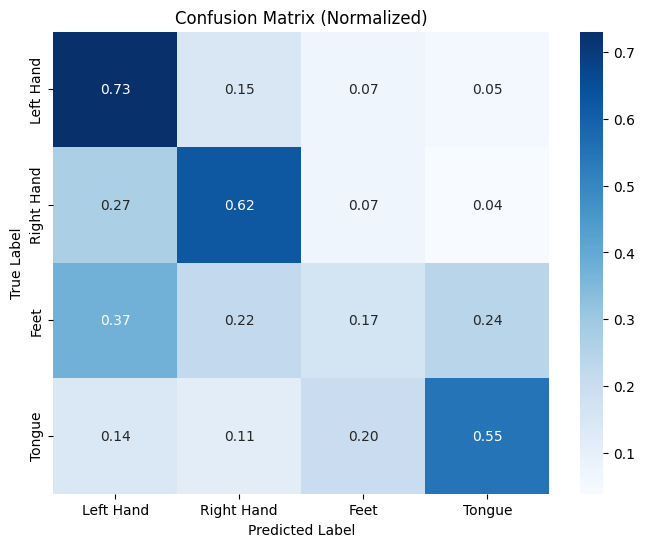

In [7]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
def eval_confusion_matrix(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model.model(X_batch)
            _, preds = torch.max(outputs, 1)
    
            all_preds.append(preds.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())
    
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    
    test_accuracy = accuracy_score(all_labels, all_preds)
    print(f'Test Accuracy: {test_accuracy:.4f}')
    
    print(classification_report(all_labels, all_preds))
    
    cm = confusion_matrix(all_labels, all_preds)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    class_names = ['Left Hand', 'Right Hand', 'Feet', 'Tongue']  # Thay thế bằng tên lớp của bạn
    
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix (Normalized)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
eval_confusion_matrix(model, val_loader)

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
import optuna


In [9]:
class MultiBranchEEGNetAE(pl.LightningModule):
    def __init__(self, 
                 num_classes=4, 
                 Chans=25, 
                 Samples=501, 
                 latent_dim=64, 
                 hidden_dim=64, 
                 dropout_rate=0.3, 
                 lr=1e-3):
        super().__init__()
        self.save_hyperparameters()

        self.eegnet = EEGNet(num_classes=num_classes, Chans=Chans, Samples=Samples)
        eegnet_features_dim = self.eegnet.flattened_size

        # AE branch
        self.ae_branch = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        # Final classifier after concatenation of EEGNet features and AE features
        self.classifier = nn.Sequential(
            nn.Linear(eegnet_features_dim + hidden_dim, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(32, num_classes)
        )

        self.criterion = nn.CrossEntropyLoss()

    def forward(self, X_raw, Z_ae):
        # EEGNet features
        eegnet_feats = self.eegnet.forward_features(X_raw)  # [B, eegnet_features_dim]
        ae_feats = self.ae_branch(Z_ae)                     # [B, hidden_dim]
        out = torch.cat((eegnet_feats, ae_feats), dim=1)
        logits = self.classifier(out)
        return logits

    def training_step(self, batch, batch_idx):
        X_raw, Z_ae, y_batch = batch
        logits = self(X_raw, Z_ae)
        loss = self.criterion(logits, y_batch)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        X_raw, Z_ae, y_batch = batch
        logits = self(X_raw, Z_ae)
        loss = self.criterion(logits, y_batch)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y_batch).float().mean()
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.hparams.lr)


In [10]:
class CombinedDataset(torch.utils.data.Dataset):
    def __init__(self, raw_data, ae_features, labels):
        self.raw_data = raw_data
        self.ae_features = ae_features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.raw_data[idx], self.ae_features[idx], self.labels[idx]

train_combined_dataset = CombinedDataset(X_train, train_features, y_train)
val_combined_dataset = CombinedDataset(X_val, val_features, y_val)

train_combined_loader = DataLoader(train_combined_dataset, batch_size=batch_size, shuffle=True)
val_combined_loader = DataLoader(val_combined_dataset, batch_size=batch_size, shuffle=False)


In [11]:
model_ae_eegnet = MultiBranchEEGNetAE(num_classes=4, 
                                      Chans=25, 
                                      Samples=501, 
                                      latent_dim=latent_dim, 
                                      hidden_dim=64, 
                                      dropout_rate=0.3, 
                                      lr=1e-3)

trainer = pl.Trainer(max_epochs=60)
trainer.fit(model_ae_eegnet, train_combined_loader, val_combined_loader)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (31) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Test Accuracy: 0.4980
              precision    recall  f1-score   support

           0       0.48      0.78      0.59       130
           1       0.54      0.59      0.57       130
           2       0.33      0.21      0.26       115
           3       0.65      0.36      0.46       115

    accuracy                           0.50       490
   macro avg       0.50      0.49      0.47       490
weighted avg       0.50      0.50      0.48       490



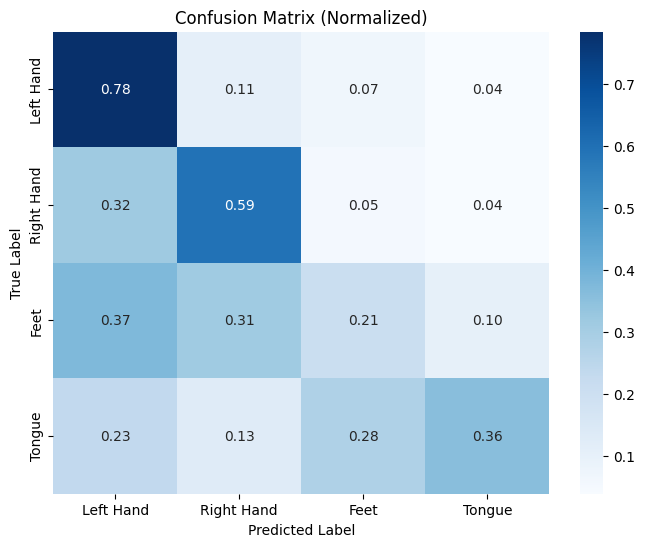

In [12]:
def combined_eval_confusion_matrix(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for X_batch, Z_batch, y_batch in val_loader:
            outputs = model_ae_eegnet(X_batch, Z_batch)
            _, preds = torch.max(outputs, 1)
    
            all_preds.append(preds.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())
    
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    
    test_accuracy = accuracy_score(all_labels, all_preds)
    print(f'Test Accuracy: {test_accuracy:.4f}')
    
    print(classification_report(all_labels, all_preds))
    
    cm = confusion_matrix(all_labels, all_preds)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    class_names = ['Left Hand', 'Right Hand', 'Feet', 'Tongue']  # Thay thế bằng tên lớp của bạn
    
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix (Normalized)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
combined_eval_confusion_matrix(model_ae_eegnet, val_combined_loader)

In [13]:
def objective(trial):
    hidden_dim = trial.suggest_int('hidden_dim', 32, 256, step=32)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5, step=0.1)
    lr = trial.suggest_float('lr', 1e-5, 1e-3, log=True)

    model_ae_eegnet = MultiBranchEEGNetAE(num_classes=4, 
                                          Chans=25, 
                                          Samples=501, 
                                          latent_dim=latent_dim, 
                                          hidden_dim=hidden_dim, 
                                          dropout_rate=dropout_rate, 
                                          lr=lr)

    checkpoint_callback = ModelCheckpoint(
        monitor='val_acc',
        mode='max',
        save_top_k=1,
        filename='best-checkpoint-{epoch:02d}-{val_acc:.2f}'
    )

    trainer = pl.Trainer(
        max_epochs=50,
        callbacks=[checkpoint_callback],
        enable_progress_bar=False,
        log_every_n_steps=1
    )

    trainer.fit(model_ae_eegnet, train_combined_loader, val_combined_loader)
    return trainer.callback_metrics['val_acc'].item()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
checkpoint_callback = ModelCheckpoint(
    monitor='val_acc',
    mode='max',
    save_top_k=1,
    filename='best-checkpoint-{epoch:02d}-{val_acc:.2f}'
)
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = study.best_params
best_model = MultiBranchEEGNetAE(num_classes=4, 
                                    Chans=25, 
                                    Samples=501, 
                                    latent_dim=latent_dim, 
                                    hidden_dim=best_params['hidden_dim'], 
                                    dropout_rate=best_params['dropout_rate'], 
                                    lr=best_params['lr'])
trainer = pl.Trainer(
    max_epochs=50,
    callbacks=[checkpoint_callback],
    enable_progress_bar=False,
    log_every_n_steps=1
)

trainer.fit(best_model, train_combined_loader, val_combined_loader)


[I 2024-12-15 07:20:50,452] A new study created in memory with name: no-name-d3dcc5da-09c8-423b-ba63-a2d017564965
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
[I 2024-12-15 07:25:39,957] Trial 0 finished with value: 0.45306122303009033 and parameters: {'hidden_dim': 256, 'dropout_rate': 0.30000000000000004, 'lr': 0.00015583105528073655}. Best is trial 0 with value: 0.45306122303009033.
[I 2024-12-15 07:30:26,760] Trial 1 finished with value:

Best trial:
  Value: 0.5428571701049805
  Params: 
    hidden_dim: 256
    dropout_rate: 0.5
    lr: 0.0006865083687392243


Test Accuracy: 0.4980
              precision    recall  f1-score   support

           0       0.48      0.78      0.59       130
           1       0.54      0.59      0.57       130
           2       0.33      0.21      0.26       115
           3       0.65      0.36      0.46       115

    accuracy                           0.50       490
   macro avg       0.50      0.49      0.47       490
weighted avg       0.50      0.50      0.48       490



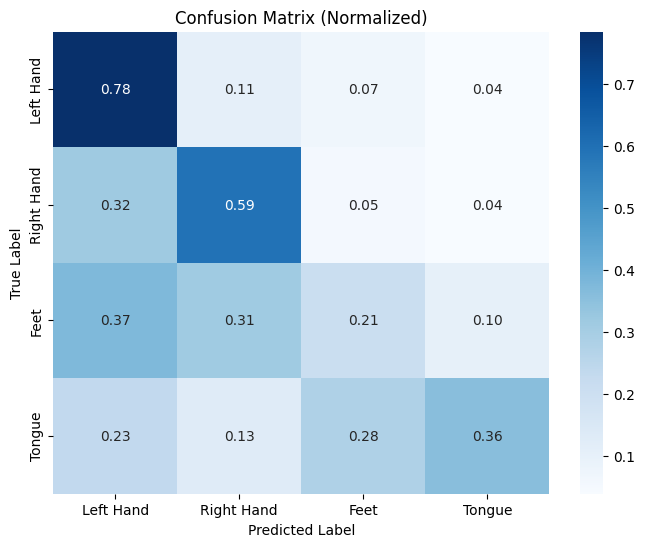

In [14]:

combined_eval_confusion_matrix(best_model, val_combined_loader)